# Empirical validation
We have two kinds of emprical validation:

1. The distributions of popularity of low-quality and high-quality memes are similar, based on data from Emergenty.info and from Hoaxy
2. We observe an amplification of low-credibility memes by bots, based on data from Hoaxy

We can tune the parameters of the model (using the empirical follower network) to reproduce these empirical observations

In [103]:
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import networkx as nx
import importlib
import bot_model
%matplotlib inline

In [104]:
fontsize = 14

## Distribution of Facebook shares from Emergent.info data

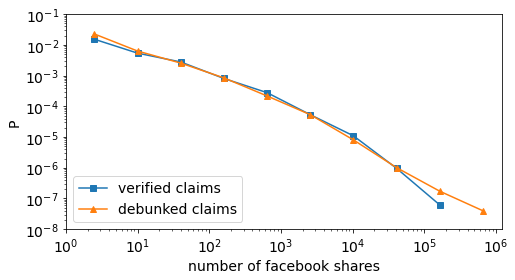

In [ ]:
popularity_low = []
popularity_hi = []
p_low_q = []
p_hi_q = []
with open('Emergent_data/Q0_distr.txt','r') as csvfile:
    plots = csv.reader(csvfile, delimiter='\t')
    for row in plots:
        popularity_low.append(float(row[1]))
        p_low_q.append(float(row[2]))
with open('Emergent_data/Q1_distr.txt','r') as csvfile:
    plots = csv.reader(csvfile, delimiter='\t')
    for row in plots:
        popularity_hi.append(float(row[1]))
        p_hi_q.append(float(row[2]))

plt.subplots(figsize=plt.figaspect(0.55))
plt.plot(popularity_hi, p_hi_q, 's-', label='verified claims', )
plt.plot(popularity_low, p_low_q, '^-', label='debunked claims')
plt.xlabel('number of facebook shares', fontsize=fontsize)
plt.ylabel('P', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1)
plt.ylim((10**-8, 0.1))
plt.legend(fontsize=fontsize, loc='lower left')
plt.tight_layout()
plt.savefig('fig_empirical_distr_fb.pdf')

## Amplification of low-credibility links by likely bots

This figure includes a superlinear fit of the data originally analyzed in https://github.com/IUNetSci/HoaxyBots/blob/master/HoaxyBotsReproduction.ipynb

Data from https://www.doi.org/10.5281/zenodo.1402266: `S8_S9_binned_claims.json`: sampled and binned tweets containing claims with bot scores for the accounts behind those tweets

In [ ]:
botThres = 0.5
fn1 = "S8_S9_binned_claims.json.txt"
binnedDataClaim = json.load(open(fn1))

In [ ]:
t = botThres
xvals, yvals = list(), list()
for b in binnedDataClaim:
  nAvail = sum([1 for s in b['bot-scores']])  
  botEst = (b['nTweets']/float(b['nArticle']))*sum([1 for s in b['bot-scores'] if s > t])/nAvail
  humanEst = (b['nTweets']/float(b['nArticle']))*sum([1 for s in b['bot-scores'] if s <= t])/nAvail
  xvals.append(botEst)
  yvals.append(humanEst)

In [105]:
# fitting power law
def linlaw(x, a, b):
  return a + x * b

In [ ]:
# log-transform
xdata_log = np.log10(xvals)
ydata_log = np.log10(yvals)
# fit linear
popt_log, _ = curve_fit(linlaw, xdata_log, ydata_log)
intercept, slope = popt_log
# recover power law points
ydatafit_log = np.power(10, linlaw(xdata_log, *popt_log))

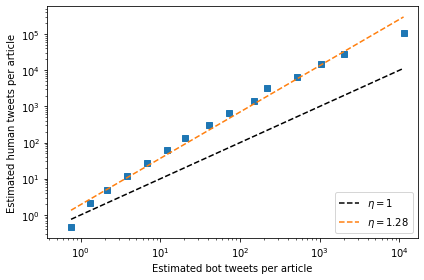

In [ ]:
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Estimated human tweets per article', fontsize=fontsize)
plt.xlabel('Estimated bot tweets per article', fontsize=fontsize)
# data points
plt.plot(xvals, yvals, 's')
# reference line
plt.plot([xvals[0],xvals[-1]], [xvals[0],xvals[-1]], 'k--', label="$\eta=1$")
# fit line
plt.plot(xvals, ydatafit_log, '--', label="$\eta={}$".format(round(slope,2)))
plt.xlim(xmin=xvals[0]*0.5,xmax=xvals[-1]*1.5)
plt.legend(loc='lower right', fontsize=fontsize)
plt.tight_layout()

## Experiments with fitted params
Fit empirical amplification and distributions, explore those parameter values

In [106]:
# We use the empirical follower network
path = "../EmpiricalNet_followers/"

In [107]:
# run this when making changes to bot_model.py
importlib.reload(bot_model)

<module 'bot_model' from '/geode2/home/u030/fil/Carbonate/Xiaodan/Manipulating-Online-Marketplace-of-Ideas/bot_model.py'>

In [164]:
# alpha=15, beta=0.01, gamma=0.01, phi=1, theta=1
follower_net = bot_model.init_net(False, verbose=False, human_network = path + 'follower_network.gml', 
                                  beta=0.01, gamma=0.01)
avg_quality_baseline = bot_model.simulation(False, network=follower_net, track_meme=True, 
                                            mu=0.5, alpha=15, phi=2, theta=5)
print('average quality baseline:', avg_quality_baseline)

average quality baseline: 0.3349121020077247


In [165]:
# distribution using bot_model.track_memes.popularity = {(meme_tuple): popularity} ...
hi_quality_pop = [bot_model.track_memes.popularity[m] for m in bot_model.track_memes.popularity if m[0] > 0]
lo_quality_pop = [bot_model.track_memes.popularity[m] for m in bot_model.track_memes.popularity if m[0] == 0]
hi_pop, hi_prob = bot_model.getbins(*bot_model.get_distr(bot_model.get_count(hi_quality_pop)))
lo_pop, lo_prob = bot_model.getbins(*bot_model.get_distr(bot_model.get_count(lo_quality_pop)))

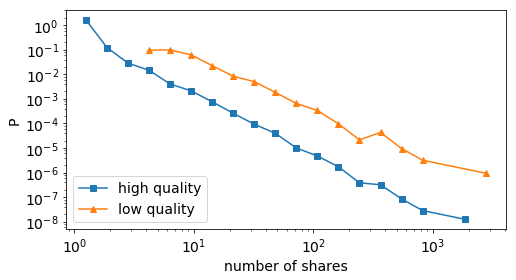

In [166]:
# plot popularity distribution
fontsize = 14
plt.subplots(figsize=plt.figaspect(0.55))
plt.plot(hi_pop, hi_prob, 's-', label='high quality', )
plt.plot(lo_pop, lo_prob, '^-', label='low quality')
plt.xlabel('number of shares', fontsize=fontsize)
plt.ylabel('P', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=fontsize, loc='lower left')
plt.tight_layout()
#plt.savefig('fig_pop_distr_followers.pdf')

In [176]:
# amplification using bot_model.track_memes.bad_popularity = {"meme_id": [human_popularity, bot_popularity]} ...
b2h = {}
for m in bot_model.track_memes.bad_popularity:
    if bot_model.track_memes.bad_popularity[m][0] > 0 and bot_model.track_memes.bad_popularity[m][1] > 0:
        b2h[bot_model.track_memes.bad_popularity[m][1]] = bot_model.track_memes.bad_popularity[m][0]
bot_shares = sorted(b2h.keys())
hum_shares = [b2h[h] for h in bot_shares]

In [177]:
# log-transform
xdata_log = np.log10(bot_shares)
ydata_log = np.log10(hum_shares)
# fit linear
popt_log, _ = curve_fit(linlaw, xdata_log, ydata_log)
intercept, slope = popt_log
# recover power law points
ydatafit = np.power(10, linlaw(xdata_log, *popt_log))

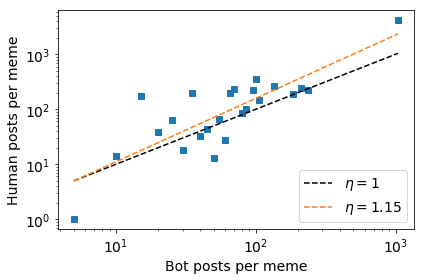

In [178]:
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Human posts per meme', fontsize=fontsize)
plt.xlabel('Bot posts per meme', fontsize=fontsize)
# data points
plt.plot(bot_shares, hum_shares, 's')
# reference line
plt.plot([min(bot_shares),max(bot_shares)], [min(bot_shares),max(bot_shares)], 'k--', label="$\eta=1$")
# fit line
plt.plot(bot_shares, ydatafit, '--', label="$\eta={}$".format(round(slope,2)))
plt.legend(loc='lower right', fontsize=fontsize)
plt.tight_layout()